In [1]:
# Start with loading all necessary libraries
import numpy as np                      #Library which enables us to word with arrays and matrices and provide other functions
import pandas as pd                     #Library for data analysis and manipulation
from os import path                     #Library to import the file 
from PIL import Image                   #Library used for performing image related operations  
!pip install wordCloud                  # A little word cloud generator 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator    #Importing other such libraries

import matplotlib.pyplot as plt          #Library for graphical analysis
#% matplotlib inline
import warnings                          #For displaying the warning messages using the warn() method

import string                            #For performing various string operations
warnings.filterwarnings("ignore")        #Never print matching warnings

from nltk.tokenize import sent_tokenize  #For generating tokens to perform other ntlk operations on the dataset

from sklearn.feature_extraction.text import CountVectorizer   #Convert a collection of text documents to a matrix of tokens count
from sklearn.feature_extraction.text import TfidfVectorizer   #Convert a collection of raw documents  to a matrix of tf-idf features
import re                                                      #Library to perform replace operations

# dowloading packages using the following commands
import nltk
nltk.download('punkt')                                   #A tokenizer which divides a text into a list of sentences
#this is nltk stopword collection
nltk.download('stopwords')                               #To import a set of all the stopwords    
nltk.download('wordnet')                                 #Importing the Lexical database

from nltk.corpus import stopwords                        #importing the stop words and the tokenizer
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Loading the the data set from excel
df = pd.read_excel(r"C:\Users\ashish\Tf-Idf-master\dataset\SMSDataset.xlsx") #importing the dataset and storing it as a dataframe

In [3]:
#Viewing the loaded dataframe
df

,Text,Classification
0,Urgent! call 09061749602 from Landline. Your c...,Spam
1,+449071512431 URGENT! This is the 2nd attempt ...,Spam
2,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,Spam
3,Urgent! call 09066612661 from landline. Your c...,Spam
4,WINNER!! As a valued network customer you have...,Spam
...,...,...
1319,Great News! Call FREEFONE 08006344447 to claim...,Spam
1320,You have WON a guaranteed £1000 cash or a £200...,Spam
1321,08714712388 between 10am-7pm Cost 10p,Spam
1322,YES! The only place in town to meet exciting a...,Spam


In [15]:
# Filtering it for Spam messages only
df2 = df.Classification.str.contains('Spam')        #collecting all the spam marked messages
df3 = df[df2]                                       
df3

df3['Text'] = df3['Text'].str.replace('\d+', '')  #Replacing the digits with empty spaces

spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","£"]          #Array of special characters

for char in spec_chars:
    df3['Text'] = df3['Text'].str.replace(char, "")   #Filtering out the special characters

df3['Text']=df3['Text'].str.lower()                   #converting all the characters to lower case
df3['Text']=df3['Text'].str.strip()                   # Removing all the spaces from the beginning and the ending
df3

# Using nltk stop words to filter it
stop_words = stopwords.words('english')              #importing the stopwords
stop_words.append('landline')
stop_words.remove('won')
print(stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')    #Pacakage used for taking the words with their Parts Of Speech

resultList=[]                                  #Pos tagging is being performed becuase wordnet Lemmatizer in python uses default
                                               #pos tag as Noun and it does not output the correct lemma for a verb unless the              
def nltk_tag_to_wordnet_tag(nltk_tag):         #pos tag is explicity mentioned as VERB
    if nltk_tag.startswith('J'):               #This function is used by the Lemmatizer function to detect the Pos tag
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):             #passing a sentence to the function
    #tokenize the sentence and find the POS tag for each token
    tokens = nltk.word_tokenize(sentence)     #sentence is tokenized and stored in tokens
    tokensNew = []
    for word in tokens:
        # replacing words in the documents
        word = re.sub(r'\btxt\b', 'text', word)
        word = re.sub(r'\bmsg\b', 'message', word)
        word = re.sub(r'\bur\b', 'your', word)
        tokensNew.append(word)
    nltk_tagged = nltk.pos_tag(tokensNew)   #creating a tuple where each token is being tagged with Its Pos tab
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)  #with the help of lamba we are passing the nltk_tagged to the ntlk_tag_to_wordnet function
    lemmatized_sentence = []                          #stores all the lemmatized sentences
    for word, tag in wordnet_tagged:
        #print("tag: " ,tag)
        if word not in stop_words:                    #Filtering for stopwords
            if tag is None:
                #if there is no available tag, append the token as it is
                lemmatized_sentence.append(word)
            else:        
                #else use the tag to lemmatize the token
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))      #if the tag is availble using it to lemmatize sentences efficiently
    resultList.append(' '.join(lemmatized_sentence))
    return " ".join(lemmatized_sentence)

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()    #importing the tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()           #importing the wordNetLemmatizer

def lemmatize_text(text):                            #functions which takes a text parameter and calls the lemmatize_sentence function and return the lemmaized senteces
    return lemmatize_sentence(text)

df3['text_lemmatized'] = df3.Text.apply(lemmatize_text)
df3

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Text,Classification,text_lemmatized
0,urgent call from landline your complimentary ...,Spam,urgent call complimentary tenerife holiday cas...
1,urgent this is the nd attempt to contact uu ha...,Spam,urgent nd attempt contact uu win call b tcsbcm...
2,free for st week no nokia tone ur mob every w...,Spam,free st week nokia tone mob every week text no...
3,urgent call from landline your complementary ...,Spam,urgent call complementary tenerife holiday cas...
4,winner as a valued network customer you have b...,Spam,winner value network customer select receivea ...
...,...,...,...
1319,great news call freefone to claim your guaran...,Spam,great news call freefone claim guaranteed cash...
1320,you have won a guaranteed cash or a prizeto ...,Spam,win guaranteed cash prizeto claim yr prize cal...
1321,between ampm cost p,Spam,ampm cost p
1322,yes the only place in town to meet exciting ad...,Spam,yes place town meet exciting adult single uk t...


In [6]:
filteredList = ' '.join([str(elem) for elem in resultList]) 
result = nltk.word_tokenize(filteredList)
print(result)                                   #printing the tokenized words

['urgent', 'call', 'complimentary', 'tenerife', 'holiday', 'cash', 'await', 'collection', 'sae', 'tc', 'box', 'hp', 'yf', 'ppm', 'urgent', 'nd', 'attempt', 'contact', 'uu', 'win', 'call', 'b', 'tcsbcmwcnxx', 'callcost', 'ppm', 'mobilesvary', 'max', 'free', 'st', 'week', 'nokia', 'tone', 'mob', 'every', 'week', 'text', 'nokia', 'get', 'txting', 'tell', 'mate', 'wwwgetzedcouk', 'pobox', 'wwq', 'normptone', 'urgent', 'call', 'complementary', 'tenerife', 'holiday', 'cash', 'await', 'collection', 'sae', 'tc', 'po', 'box', 'wa', 'px', 'ppm', 'sender', 'hol', 'offer', 'winner', 'value', 'network', 'customer', 'select', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hour', 'okmail', 'dear', 'dave', 'final', 'notice', 'collect', 'tenerife', 'holiday', 'cash', 'award', 'call', 'tc', 'sae', 'box', 'cwwx', 'ppm', 'rodger', 'burn', 'message', 'try', 'call', 'reply', 'sm', 'free', 'nokia', 'mobile', 'free', 'camcorder', 'please', 'call', 'delivery', 'tomorrow', 'urg

In [7]:
#Applying tf-idf Vectorizer from sklearn package
vectorizer = TfidfVectorizer(stop_words = stop_words)
vectors = vectorizer.fit_transform(df3['text_lemmatized'])   #Applying the td-idf to the lemmatized text
feature_names = vectorizer.get_feature_names()               #extracting all the features 
dense = vectors.todense()                                    # To allocate space  value even to missing values
denselist = dense.tolist()                                   
df1 = pd.DataFrame(denselist, columns=feature_names) #printing the dataframe
df1

,ab,abta,access,accommodationvouchers,accordingly,account,aclpm,acoentry,action,activate,...,yesterday,yf,youre,youto,youve,yr,yrs,zed,zf,zouk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.390102,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.359945,0.0,0.0,0.0,0.0
319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [8]:
terms = vectorizer.get_feature_names()  #getitng the names of all the terms

# sum tfidf frequency of each term through documents
sums = vectors.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):               #associating each term with its tfids weights
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])    #printing all the terms in the descending order of their scores
#print(ranking.sort_values('rank', ascending=False))
ranking = ranking.sort_values('rank', ascending=False)
ranking

,term,rank
101,call,20.087207
1017,win,13.665771
892,text,13.426717
298,free,12.784724
686,prize,12.773926
...,...,...
150,colin,0.220313
282,film,0.220313
281,farrell,0.220313
538,msgticketkioskvalid,0.220313


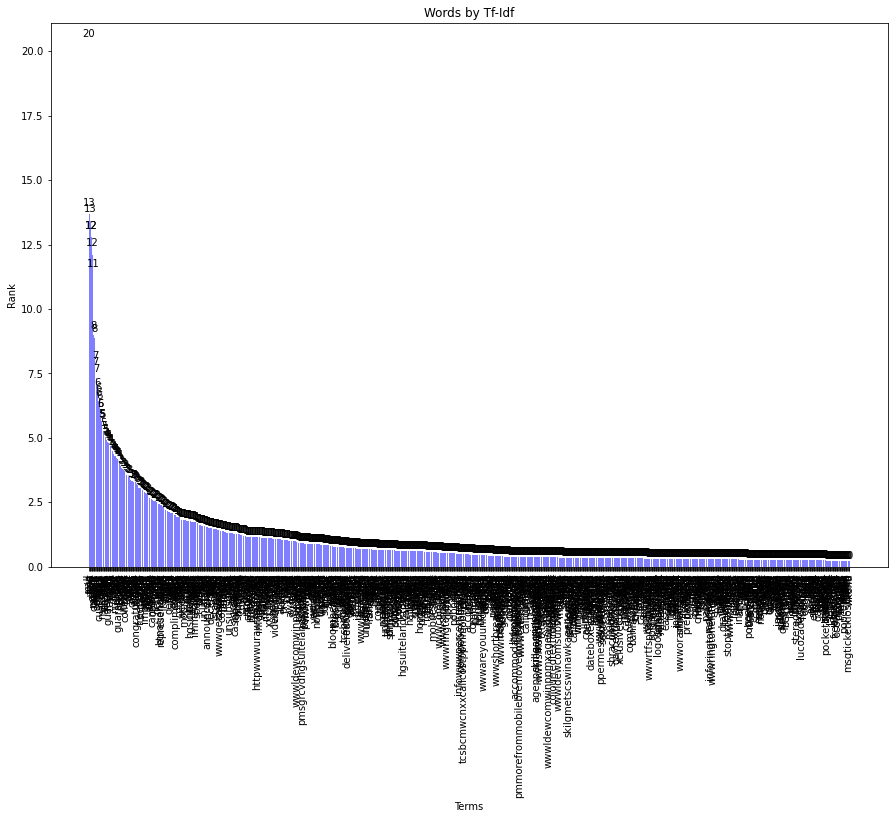

In [9]:
#Plotting it to bar plot 

#Defining chart size
fig, ax = plt.subplots(figsize=(15,10))
rects = plt.bar(ranking['term'], ranking['rank'], align='center', alpha=0.5, color = 'blue')
plt.xticks(rotation = 90)
ax.set_title("Words by Tf-Idf")
ax.set_xlabel("Terms")
ax.set_ylabel("Rank")

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 1.02*height, '%d'%int(height),
                ha='center', va='bottom')

autolabel(rects)

plt.show()

In [10]:
#Using Count Vector to covert the string to matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(result)

#Creating dataframe with the string values and count of them
dataframe = pd.DataFrame(np.sum(X, axis=0), columns=vectorizer.get_feature_names(), index =['count'])
dataframe

# Transposing the dataframe created
dataframe_transposed = dataframe.T
dataframe_transposed

# Sorting the dataframe based on the mostly used words to least used words
dataframe_sorted = dataframe_transposed.sort_values(by=['count'], ascending=False)
dataframe_sorted.index.name = 'word'
dataframe_sorted = dataframe_sorted.reset_index()
dataframe_sorted

# Taking only the first 10 values for plotting
dataframe_final = dataframe_sorted.head(10)
dataframe_final

,word,count
0,call,184
1,text,117
2,free,89
3,win,82
4,mobile,70
5,claim,67
6,prize,65
7,nokia,41
8,urgent,41
9,contact,40


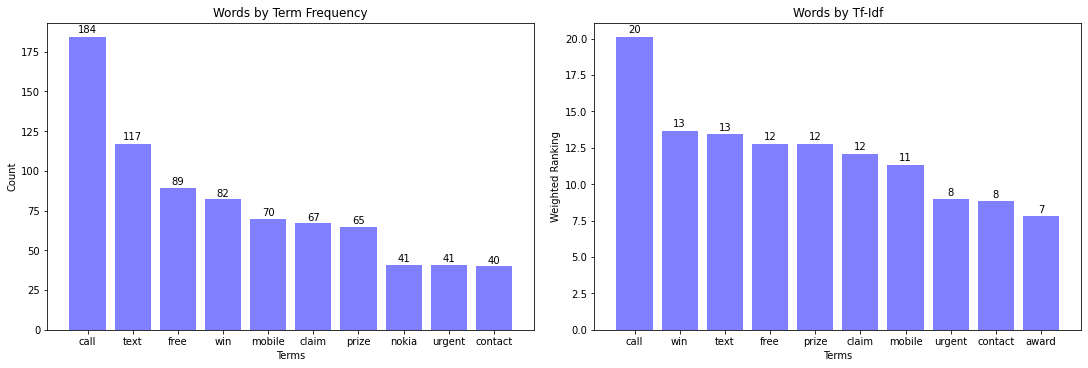

In [11]:
rankingFew = ranking.head(10)

#Plotting it to bar plot 
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(15,5))

rects1 = axs[0].bar(dataframe_final['word'], dataframe_final['count'], align='center', alpha=0.5, color = 'blue')
axs[0].set_title("Words by Term Frequency")
axs[0].set_xlabel("Terms")
axs[0].set_ylabel("Count")

for rect in rects1:
        height = rect.get_height()
        axs[0].text(rect.get_x()+rect.get_width()/2, 1.01*height, '%d'%int(height),ha='center', va='bottom')

rects2 = axs[1].bar(rankingFew['term'], rankingFew['rank'], align='center', alpha=0.5, color = 'blue')

for rect in rects2:
        height = rect.get_height()
        axs[1].text(rect.get_x()+rect.get_width()/2, 1.01*height, '%d'%int(height),ha='center', va='bottom')
        
#plt.xticks(rotation = 45)
axs[1].set_title("Words by Tf-Idf")
axs[1].set_xlabel("Terms")
axs[1].set_ylabel("Weighted Ranking")

plt.show()